In [8]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/'My Drive'/'All_Repos'/Self-Driving-Car-NanoDegree/CarND-Traffic-Sign-Classifier-Project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Traffic-Sign-Classifier-Project


## Step 1: Dataset Summary & Exploration

The German Traffic Sign Benchmark is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. This dataset consists of color channel images of shape (32,32,3) split into train, test and validation sets. The datasets are loaded from pickle dumps of resized images. There are 43 different classes of images as shown below. 

### Load image data

In [0]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [14]:
import numpy as np


### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Exploratory Visualization

The plot below shows the images in the pickled data. One image from each class is shown below.

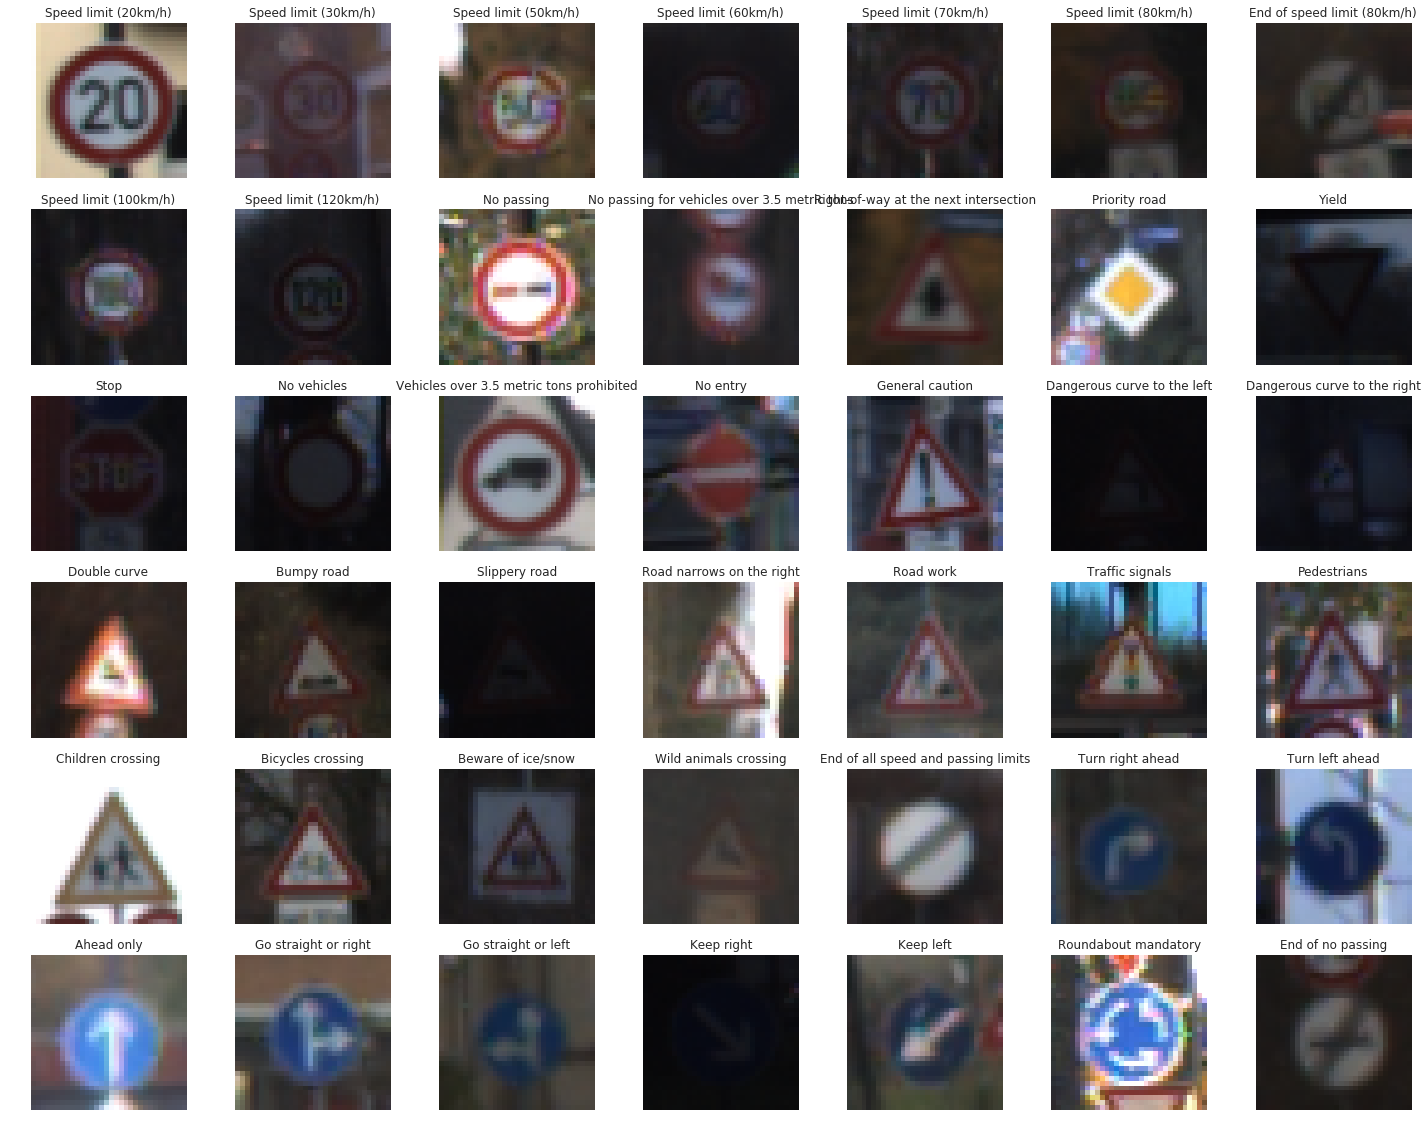

In [42]:
import pandas as pd

names = pd.read_csv('dataset/signnames.csv')
names.set_index(['ClassId'],inplace=True)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 7, figsize=(25, 20))
count = 0

for i in range(6):
  for j in range(7):
    axs[i][j].imshow(X_train[np.where(y_train == count)[0][0]])
    #print(names.loc[5].SignName)
    axs[i][j].set_title(names.loc[count].SignName)
    axs[i][j].set_axis_off()
    count+=1

plt.show()

## Unbalanced Datasets

As mentioned above, the German Traffic Signs dataset consists of 43 different classes of images. But not all classes have equal number of samples. The class names for the labels can be referenced from [signnames.csv](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/signnames.csv) file. 

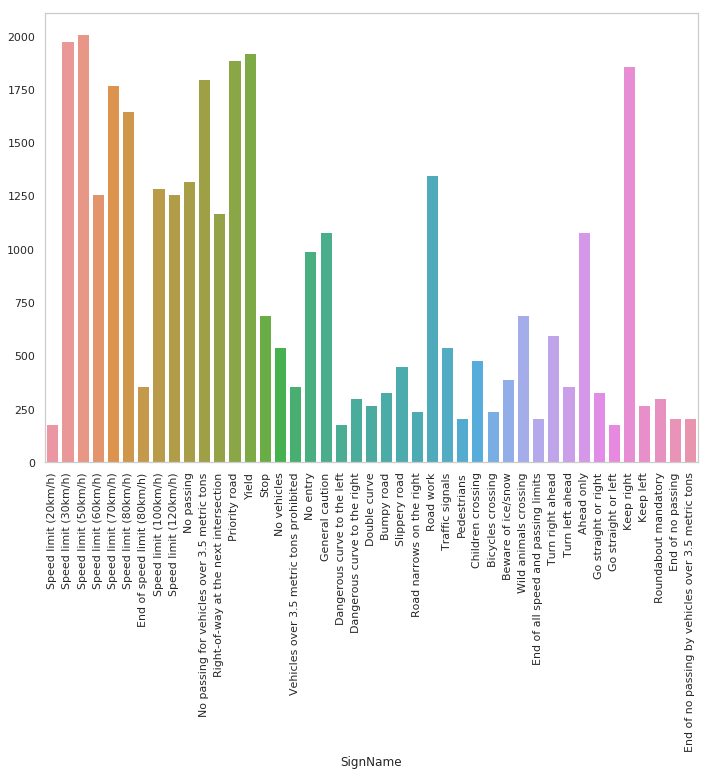

The class 'Speed limit (20km/h)' has the least number of samples > sample count = 180
The class 'Speed limit (50km/h)' has the maximun number of samples > sample count = 2010


In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
df = pd.read_csv("signnames.csv")

uniques,counts = np.unique(y_train,return_counts=True)
g = sns.barplot(df.SignName,counts)
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

print("The class '{0}' has the least number of samples > sample count = {1}".format(df.SignName.iloc[np.argmin(counts)], counts[np.argmin(counts)]) )
print("The class '{0}' has the maximun number of samples > sample count = {1}".format(df.SignName.iloc[np.argmax(counts)], counts[np.argmax(counts)]) )

## Problem of unbalanced dataset

An unbalanced dataset is of concern because of two main reasons

1. If some of the classes are poorly represented in our dataset, the model doesn't get sufficient look at these samples. Hence the model tends to overfit the data to those classes that have ample representation
2. When trying to create a validation set from such an unbalanced dataset, we cannot be sure of having samples from each class if some of them have too few samples

Hence there is a need to balance the class distribution. The ideal way of balancing the dataset is collecting more data for these classes. But this is usually a time consuming and a costly exercise. An artificial way of adding more data to a class is referred to as data augmentation. 

## Augmenting Data

Data augmentation is a technique by which we build a jittered dataset by adding random perterbations to the existing dataset.  This serves two main purposes. By adding randomly peturbed images to the dataset we increase the sample count of the class and hence augment the data. Also, when a dataset does not naturally contain such random perturbations, adding them synthetically will make the model more robust to such perturbation that might be present in the test set. 

### Types of Perturbations

The augmented set is generated by perturbing the original image in several ways. In this implementation the following random perturbations are used

#### 1.  Brightness Augmentation
The image is converted to HSV color space and the value channel is multiplied by a random number that alters the image brightness. The image is then converted back to RGB and appended to the training dataset. 

#### 2. Translation 
The image is translated in x and y direction by a random integer between (0,5). Thus the new image is shifted slightly to the right and bottom due to this perturbation

#### 3. Rotation
This method , like translation, uses `cv2.warpaffine` method to rotate the original image by an angle between 0 and 20 degrees 

#### 4. Shear
Shearing an image produces the effect of capturing an image with the image sensor not being parallel to the object. This is also achieved using the `cv2.warpaffine` function by defining a shear matrix as shown below

These transformations as only applied to those classes whose count is less than 800. Thus we ensure that every class has atleast 800 samples in them and thus have considerable infuence on the model weights. 

The code block below shows how the transformations were performed. 


In [0]:

import random
import tensorflow as tf
from sklearn.utils import shuffle
import cv2
import time
import sys

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
  
  
def transforms(X_train,y_train):
  
  images,labels = X_train,y_train
  
  for i,img in enumerate(images):
    
    uniques_new,counts_new = np.unique(labels,return_counts=True)

    #print(counts_new[labels[i]])
    if counts_new[labels[i]] < 800:
      # Image Brightness
      brit_img = augment_brightness_camera_images(img).reshape(1,32,32,3)
      
      #Translation
      translation_matrix = np.float32([ [1,0,random.randint(0,5)], [0,1,random.randint(0,5)] ])
      img_translate = cv2.warpAffine(img, translation_matrix, (32, 32))      
      img_translate = img_translate.reshape(1,32,32,3)
      
      # Shear
      pts1 = np.float32([[5,5],[20,5],[5,20]])

      pt1 = 5+10*np.random.uniform()-10/2
      pt2 = 20+10*np.random.uniform()-10/2
      
      pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
      
      shear_M = cv2.getAffineTransform(pts1,pts2)     
      img_shear = cv2.warpAffine(img, shear_M, (32, 32)).reshape(1,32,32,3)
      
      #Rotation
      rotation_matrix = cv2.getRotationMatrix2D((16,16),random.randint(0,20),1)
      img_rotate = cv2.warpAffine(img, rotation_matrix, (32, 32))
      img_rotate = img_rotate.reshape(1,32,32,3)
      
      images = np.concatenate((images,np.array(brit_img)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)
      images = np.concatenate((images,np.array(img_translate)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)
      images = np.concatenate((images,np.array(img_rotate)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)
      images = np.concatenate((images,np.array(img_shear)),axis=0)
      labels = np.append(labels,np.array(labels[i]).reshape(1,),axis=0)      
  
  return images,labels
      
time0 = time.time()
print(X_train.shape)
X_train_new,y_train_new = transforms(X_train,y_train)
time1 = time.time()
elapsed = time1-time0
print(elapsed)
print(X_train_new.shape)





(34799, 32, 32, 3)
464.0905246734619
(46507, 32, 32, 3)


It can be seen above for the length of the new training set that new images have been added to the dataset. Plotting the class dirstribution like before shows a much more balanced distribution compared to the raw dataset

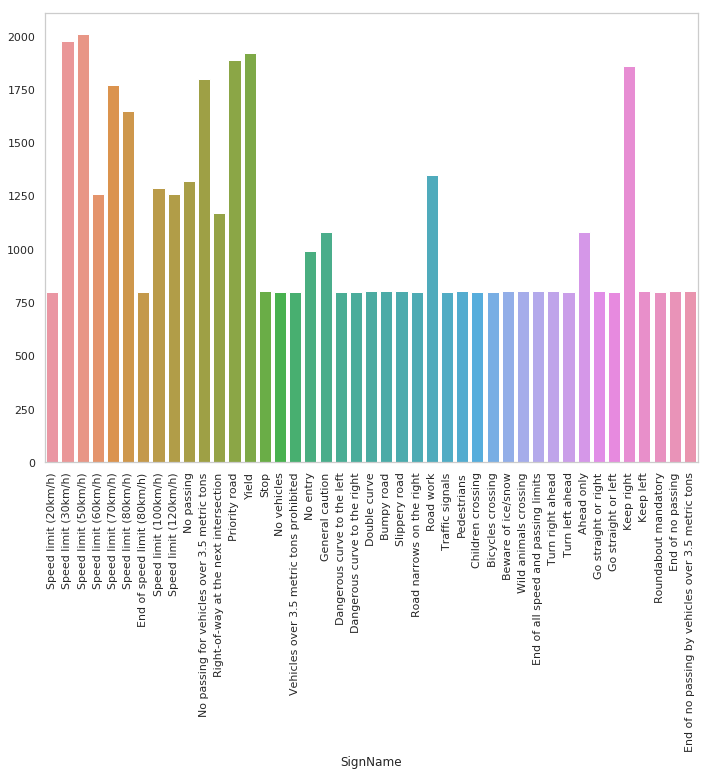

In [43]:
import matplotlib.pyplot as plt
with open('dataset/augmented_train.p', mode='rb') as f:
    aug_dataset = pickle.load(f)
X_train = aug_dataset['X_train']
y_train = aug_dataset['y_train']

import numpy as np
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
df = pd.read_csv("signnames.csv")

uniques,counts = np.unique(y_train,return_counts=True)
g = sns.barplot(df.SignName,counts)
plt.xticks(rotation=90)
plt.grid(False)
plt.show()

## Pickle dump the Augmented Data

In [0]:
#aug_data = {'X_train':X_train_new, 'y_train':y_train_new}
aug_data_file = 'dataset/augmented_train.p'
with open(aug_data_file, mode='rb') as f:
    train = pickle.load(f)

## Augmented Data

### Translate, Rotate, Shear, Brightness 

A sample output from the augment set is shown below. The new images added to the dataset come from the random translations, rotations, shear deformations and brightness augmentation to the original image. 

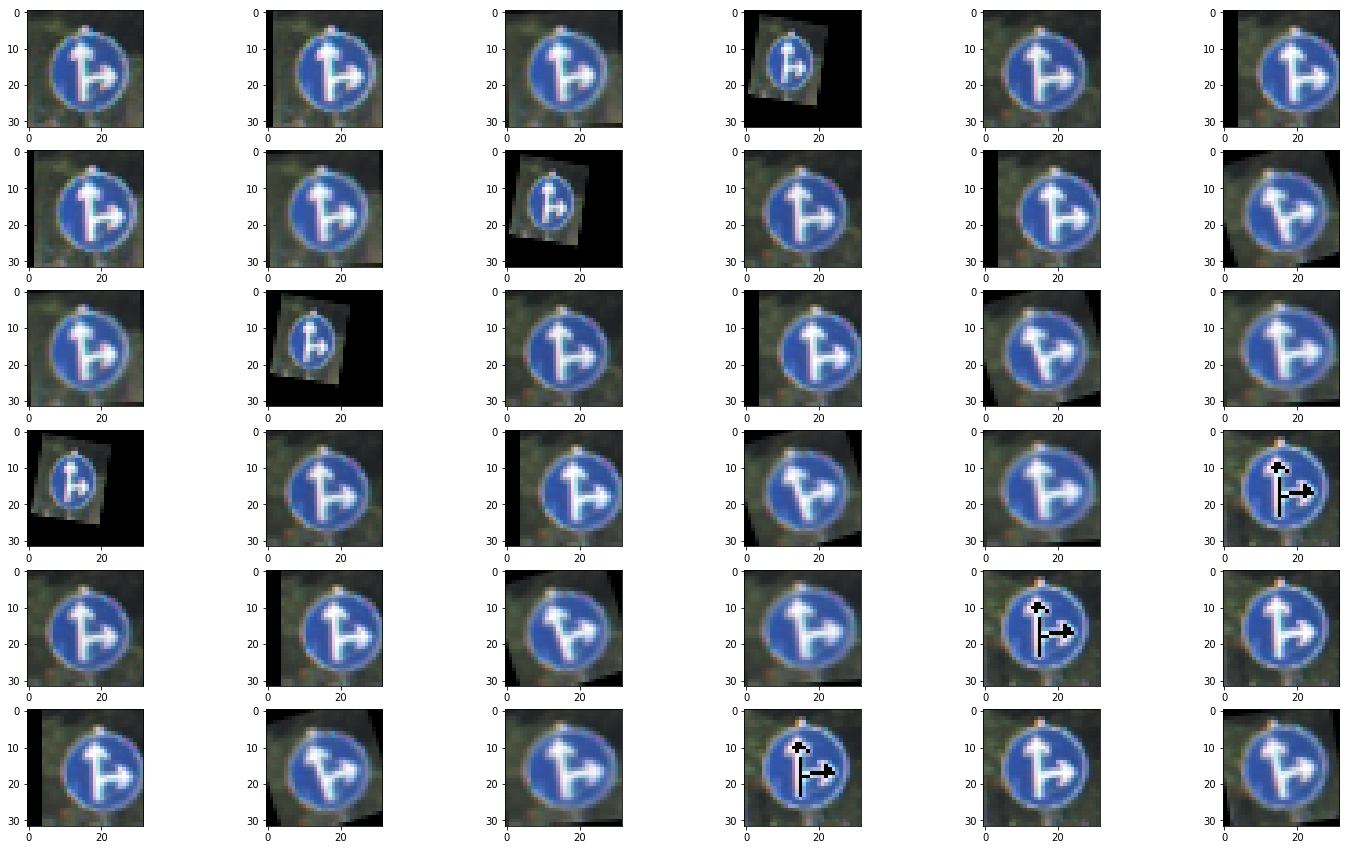

In [0]:
X_train = train['X_train']
fig,axs = plt.subplots(6,6,figsize=(25,15))
for i in range(6):
  for j in range(6):
    axs[i][j].imshow(X_train[35799+(i+j)])
    
plt.show()
    
  

## Model Architecture

<center><img src="https://docs.google.com/uc?export=download&id=1Ct01XI3Fof8KckS1xRn4aGzYkY43-uZg" width=500 /> </center>

The model architecture is based on [Yan LeCun's LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) architecture shown above. 

The architecture has 5 layers - 2 convolutional and 3 fully connected layers. In order to prevent the model from overfitting, a dropout layer is added between layers 3 and 4. 

Below is the description of model architecture.

| Layer                 |     Description                               | 
|:---------------------:|:---------------------------------------------:| 
| Input                 | 32x32x3 input image                      | 
| Convolution 5x5       | 1x1 stride, VALID padding, outputs 28x28x16     |
| RELU                  |                                               |
| Max pooling           | 2x2 stride, outputs 14x14x16                   |
| Convolution 5x5       | 1x1 stride, VALID padding, outputs 10x10x32    |
| RELU                  |                                               |
| Max pooling           | 2x2 stride, outputs 5x5x32                    |
| Flatten               | output 800                                    |
| Drop out              |                                               |
| Fully connected       | output 240                                    |
| RELU                  |                                               |
| Fully connected       | output 84                                     |
| RELU                  |                                               |
| Fully connected       | output 43                                     |

## Hyper-Parameter Tuning

CNNs have several hyper parameters that contribute to their performance. Hyper parameter tuning is an involved process that can lead to significant performance improvements. 

|                  |     Lerning Rate   |    Epoch     |    Keep Prob    |   Beta    |   Train Accuracy |Validation Accuracy | Test Accuracy |
|:--------------:|:--------------------------:|:----------------:|:----------------------:|:------------:|:----------------------------------:|:-----------------------:|:-----------------------:|
|Final Iteration  |   0.0006  | 175 | 0.5 | 0.001|0.999 | 0.973 | 0.964 |
|